# Decision Trees and Random Forests

It is even today (2020) not too rare that a random forest classifier can beat an ann in some simple tabular classification tasks. Moreover, especially shallow tree classifier provide intuitive interpretability that can be of great importance in several application areas. The whole question of model interpretability is actually very important and has only lately been started to receive the attention it deserves giving the tree classifiers some headway against some of the other ML models, namely neural networks. Considering all this, there is some room for these methods to be presented in a course of ML even if the neural networks are outshining everything else in many fields. 
***
#### Here we present:
2. What is a Tree Classifier
3. How do you use Tree Classifier in sklearn and what to keep in mind when using it.
3. *Optional* - What is information entropy and how is Tree Classifier build using it. 
4. Understand what is and how to visualize the decision path from a tree classifer.
5. What is a random forest classifier (RF).
6. Why it interpretation of RF is difficult as compared tree classifier.
7. Plot the decision surfaces in simple cases for visualization.
8. Explore a non-trivial dataset and try to build understanding of it before doing ML.
8. Finally go and use RF to classify items in a non-trivial dataset.
9. Try to optimimze the performance of the RF classifier in the non-trivial case.
10. Report the results and compare against a dummy classifier.

***
#### Def 1. A computer program is said to learn from *experience* **E** with respect to some class of *tasks* **T** and *performance measure* **P**, if its performance at tasks in **T** as measured by **P**, improves with experience **E**. 

-Mitchell, T. (1997). Machine Learning.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns 
import pandas as pd
from sklearn.model_selection import train_test_split

%matplotlib inline 
# Define some plotting params:
mpl.rcParams['figure.figsize'] = (12,6)
sns.set_style("ticks") #, {"axes.facecolor": ".99"})
random_state = 42

# Load the penguins dataset:
data = sns.load_dataset('penguins').dropna()

# Define the target:
target = 'species'

X = data.drop(columns=target)
y = data.loc[:, target]

## Tree Classifier

Tree classifiers are one of the simplest ML methods out there. Tree training is based on a process where at each node you find a feature and a split value (f, $x_f$) such that if the instances in that current node are splitted accordingly the resulting two nodes are as *pure* as possible. This is continued until no split can be performed (pure nodes) or a termination condition is reached. We shall make this clear by example. However, let us first import a tress classifier and cross validate its performance in the penguins dataset. 

In [2]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_validate


tree = DecisionTreeClassifier(max_depth=2, criterion='entropy')

print('Mean test score in cross validation: ', cross_validate(tree, X, y)['test_score'].mean())

Mean test score in cross validation:  nan


/home/topiko/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/topiko/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/topiko/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/home/topiko/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 156, in fit
    X, y = self._validate_data(X, y,
  File "/home/topiko/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/home/topiko/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py", line 72, in inner_f

What is this! The stuff crashed. Lets look at the data training data $\mathbf{X}$. Notice the features **island** and **sex**. They are objects and thus tree classifier crashes whren trying to find splits by comparing: female > male... Here we shall encode this feature values to numerical ones.

In [3]:
X.head()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Torgersen,39.3,20.6,190.0,3650.0,Male


In [4]:
from sklearn.preprocessing import OrdinalEncoder

tmp_df = X.loc[:,['sex']].copy()
tmp_df.loc[:, 'encoded_sex'] = OrdinalEncoder().fit_transform(X.loc[:, ['sex']]).flatten()
tmp_df

,sex,encoded_sex
0,Male,1.0
1,Female,0.0
2,Female,0.0
4,Female,0.0
5,Male,1.0
...,...,...
338,Female,0.0
340,Female,0.0
341,Male,1.0
342,Female,0.0


### Let us the use column transformer to encode all the categorical columns:

In [5]:
from sklearn.compose import ColumnTransformer, make_column_selector

ct = ColumnTransformer([('cat', OrdinalEncoder(), make_column_selector(dtype_include=['category', object]))], remainder='passthrough')
X_encoded = ct.fit_transform(X)
X_encoded, type(X_encoded)

(array([[2.00e+00, 1.00e+00, 3.91e+01, 1.87e+01, 1.81e+02, 3.75e+03],
        [2.00e+00, 0.00e+00, 3.95e+01, 1.74e+01, 1.86e+02, 3.80e+03],
        [2.00e+00, 0.00e+00, 4.03e+01, 1.80e+01, 1.95e+02, 3.25e+03],
        ...,
        [0.00e+00, 1.00e+00, 5.04e+01, 1.57e+01, 2.22e+02, 5.75e+03],
        [0.00e+00, 0.00e+00, 4.52e+01, 1.48e+01, 2.12e+02, 5.20e+03],
        [0.00e+00, 1.00e+00, 4.99e+01, 1.61e+01, 2.13e+02, 5.40e+03]]),
 numpy.ndarray)

### Kräp, it return an numpy array and even mixes up the column order :( 
As we would like to continue working with a dataframe we need to get the order of the columns in X_encoded. Luckily ColumnTransformer has a function get_feature_names(), however it only works if the underlying transformers all implement get feature names as well. By default (obviously) OrdinalEncoder doesn't... No worries though, we can easily extend the sklearns OrdinalEncoder to be our super OrdinalEncoder...

In [6]:
from sklearn.compose import ColumnTransformer, make_column_selector

class OrdinalEnc(OrdinalEncoder):
    """
    The original ordinal encoder does not return feature names for some reason. Let us implement a 
    version of it that does. We will use the feature names to build an dataframe.
    """
    def __init__(self):
        super().__init__()
        
    def fit(self, X, y=None):
        self.features = X.columns
        return super().fit(X, y)
    
    def get_feature_names(self):
        return self.features


display(X.head())

try:
    ct = ColumnTransformer([('cat', OrdinalEnc(), make_column_selector(dtype_include=['category', object]))], remainder='passthrough')
    X = ct.fit_transform(X)
    # Create the dataframe from the numpy array and feature names.
    X = pd.DataFrame(data=X, columns=ct.get_feature_names())
except ValueError:
    pass
 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
print('After encodind the categorical features:')
X.head()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Torgersen,39.3,20.6,190.0,3650.0,Male


After encodind the categorical features:


,cat__island,cat__sex,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,2.0,1.0,39.1,18.7,181.0,3750.0
1,2.0,0.0,39.5,17.4,186.0,3800.0
2,2.0,0.0,40.3,18.0,195.0,3250.0
3,2.0,0.0,36.7,19.3,193.0,3450.0
4,2.0,1.0,39.3,20.6,190.0,3650.0


***
## The inner workings of a DecisionTree:
You need to undestand what a histogram/distribution is to get the point of the below cell.

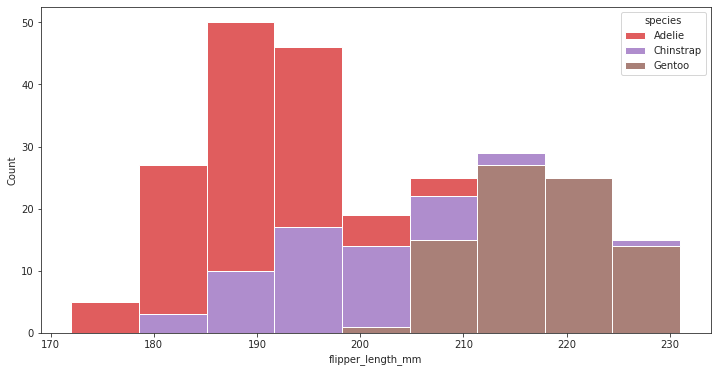

In [7]:
penguin_palette = {sp:'C{}'.format(i+3) for i, sp in enumerate(np.unique(y_train))}

_ = sns.histplot(x=X.loc[:,'flipper_length_mm'], hue=y_train, multiple='stack', palette=penguin_palette)

In [8]:
from sklearn.preprocessing import LabelEncoder
from dtreeviz.trees import *

tree_clf = DecisionTreeClassifier(max_depth=3)  # limit depth of tree

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
tree_clf.fit(X_train, y_train_enc)


viz = dtreeviz(tree_clf,
               X_train,
               y_train_enc,
               target_name='variety',
               feature_names=X_train.columns, 
               class_names=list(le.classes_),
               scale=2,
               X=X_test.iloc[0]) 
              
viz.view()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


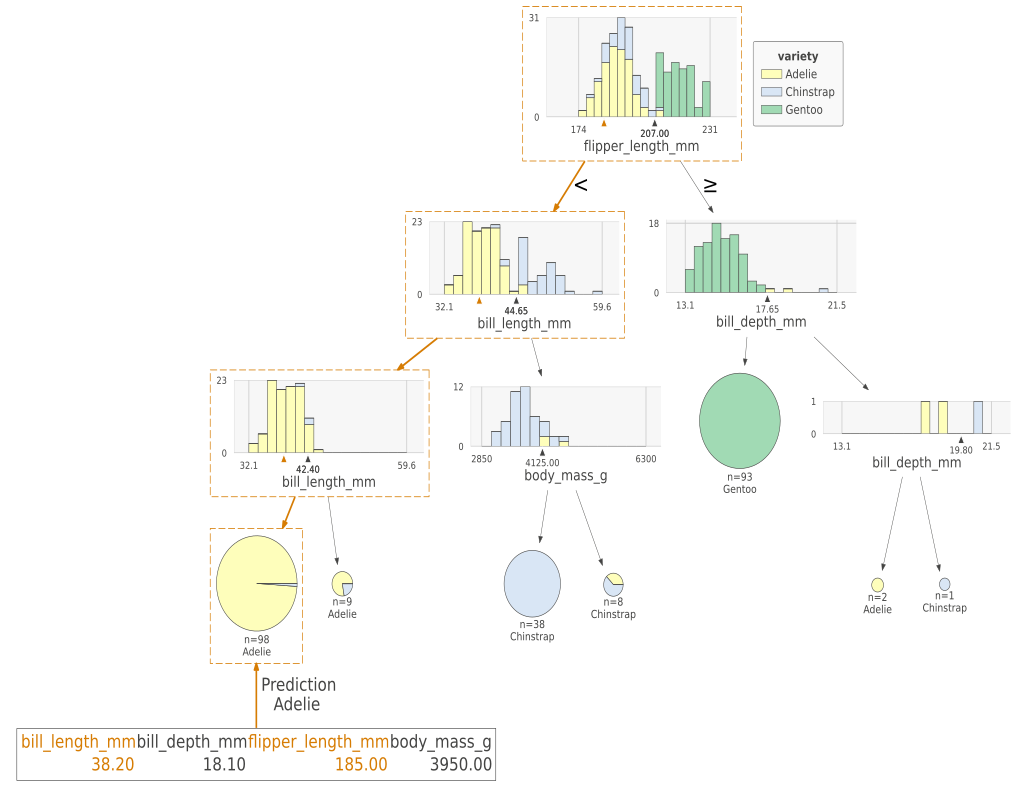

In [9]:
#In case above cell crashes due to missing graphviz or so
from IPython.display import Image

Image("DecisionPath.png")

### What happens when a tree classifier is trained?

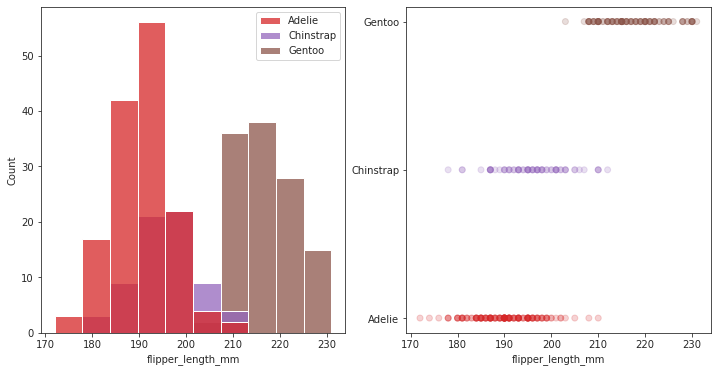

In [10]:
from sklearn.preprocessing import LabelEncoder

xlabel = 'flipper_length_mm'
xtmp = X.loc[:, xlabel].values
ytmp = y.values
get_c = lambda prob: plt.cm.PRGn(prob)


def plot_hist_2ax(x, y, xs=None, I=None):

    # Sort by the x values.
    sort_idx = x.argsort()
    x = x[sort_idx]
    y = y[sort_idx]
    
    # Create the figure:
    _, (ax1, ax2) = plt.subplots(1, 2)
    
    # Left histogram:
    sns.histplot(x=x, hue=y, ax=ax1, palette=penguin_palette) #, multiple='stack') 
    
    # Right scatter plot:
    colors = [penguin_palette[sp] for sp in y]
    ax2.scatter(x, y, alpha=.2, c=colors) 
    
    # Only when split value is given.
    if xs is not None:
        ax3 = ax2.twinx()
        ax3.plot(xs, I, color='black', label= 'Information Gain')
        ax3.vlines(xs[I.argmax()], *ax3.get_ylim(), linestyles='dashed', color='black', label='Split at: {:.1f}'.format(xs[I.argmax()]))
        ax3.set_ylabel('IG')
        ax1.vlines(xs[I.argmax()], *ax1.get_ylim(), linestyles='dashed', color='black')
        plt.legend(frameon=False, loc=2)
   
    ax1.set_xlabel(xlabel)
    ax2.set_xlabel(xlabel)
    plt.show()

plot_hist_2ax(xtmp, ytmp)

#### Where to split?
In the above figure: how would you find a split value x such that the two sets splitted by xlabel < x and xlabel >= x would be a pure as possible? What does pure even mean?
***
## Math behind tree node splitting (OPTIONAL):
(For intro to infromation theory look at: [deeplearningbook_information](https://www.deeplearningbook.org/contents/prob.html))

First we though need to define what *pure* means. We can measure the purity of a node by the amount of information entropy:

$
H(y) = -\sum_{i \in \text{classes}}  p(i) \log_2 p(i),
$

where $p(i)=\frac{n_i}{n}$ is the probability to find instances of class $i$ in node under consideration. One can see that if $p(i) \in \{0, 1\}$ the contribution is of the corresponding term is 0. That is, totally pure nodes ($p(i) \in \{0, 1\} \forall i$) have $H=0$. We want to use $H$ to reason by which feature to split and where to place the split boundaries (see above fig.). Such a split is based on information gain, the split can be also be found by using Gini inpurity as purity measure, anyhow the point is to maximize *purity* the chosen measure is often unimportant (you can try ths by comparing a tree classifier with setting *criterion* either to 'entropy' or 'gini'). 

After a given split (*feature*, $t$) we obtain two nodes - one on the left for instances with $\mathcal{L} = \{(\mathbf{x}, y) | x_\text{feature} < t, ~ \mathbf{x} \in \mathbf{X}_\text{train}\}$ and the other on the right for intances $\mathcal{R} = \{(\mathbf{x}, y) | t \leq x_\text{feature}, ~\mathbf{x} \in \mathbf{X}_\text{train} \}$. We consider *information gain* in this split process: 

$
\text{IG}(y, a) = H(y) - H(y|a),  
$ 

where $a \in \{\mathcal{L}, \mathcal{R}\}$ and $H(y|a)$ is the *conditional entropy*, that is, the information entropy that still remains when knowledge of the split side ($\mathcal{L}, \mathcal{R}$) is exposed. This can be viewed as asking "if I have a = $\mathcal{L}$ what I can say about y?".

$
H(y|a) = -\sum_{i \in \text{classes}} p(i|a) \log_2 p(i|a)
$

If the node is pure then conditional entropy goes to zero since the target class is completely determined by the split side. We perform split such that the expectation value of information gain is maximized, i.e.,

$
\text{I}(y; A) = \text{E}_A[\text{IG}(y, a)] = H(y) - \sum_{a\in\{\mathcal{L}, \mathcal{R}\}} p(a) H(y|a).
$

Equipped with above Eq. one only needs to find a split that maximizes the *mutual information* I$(y;A)$.  
***

Survived? We can agree that there is a concept of *information gain*, it will depend on where we decide to split and it will increase in value the better the split is. 

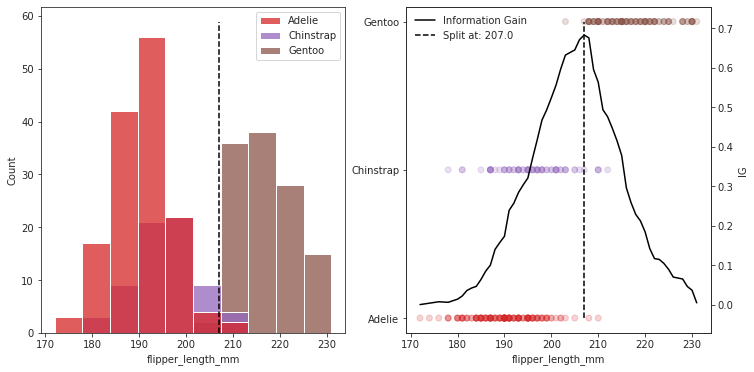

In [11]:
# This cell implement the above mainly to find the split values so I can plot them
# Do not worry about the details. Unless you do not want to improve this...
from scipy.stats import entropy as entropy_scipy


entropy = lambda pk: entropy_scipy(pk, base=2)

def get_prob(y):
    labels, pk = np.unique(y, return_counts=True)
    return labels, pk/pk.sum()

def get_lr_xy(x,y, split_value):
    sort_idx = x.argsort()
    x = x[sort_idx]
    y = y[sort_idx]
    mask_left = x < split_value
    mask_right = x >= split_value
    
    return x[mask_left], y[sort_idx][mask_left], x[mask_right], y[sort_idx][mask_right]

def get_entropies_lr(x, y, split_value):
    xl, yl, xr, yr = get_lr_xy(x,y, split_value)
    
    probs_left = get_prob(yl)[1]
    probs_right = get_prob(yr)[1]
    
    return len(yl), entropy(probs_left), len(yr), entropy(probs_right)

def get_conditional_entropy(x, y, split_value):
    nl, hl, nr, hr = get_entropies_lr(x, y, split_value)
    N = nl + nr
    return nl/N * hl + nr/N * hr
    
def get_split(x, y):
    xs = sorted(np.unique(x))
    I = np.ones(len(xs))*entropy(get_prob(y)[1])
    
    for i, split_value in enumerate(xs):
        hxs = get_conditional_entropy(x, y, split_value)
        I[i] -= hxs
    
    return xs[I.argmax()], xs, I

split_value, xs, I = get_split(xtmp, ytmp)
plot_hist_2ax(xtmp, ytmp, xs, I)

#### This time the same feature is not a good candidate for splitting in the resulting leaves:

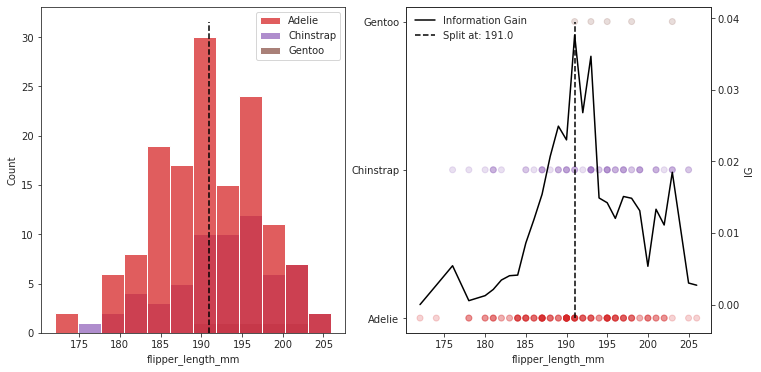

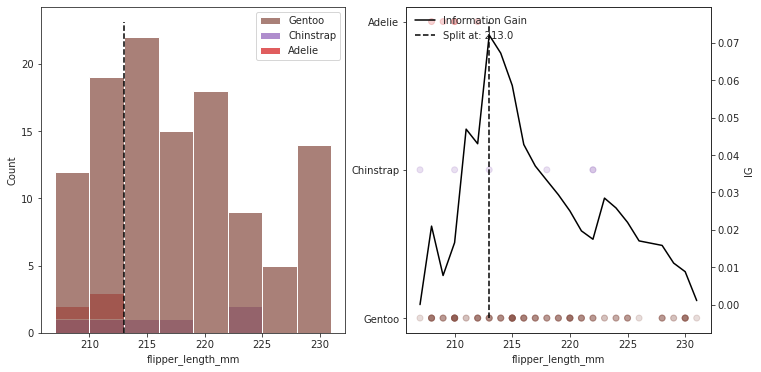

In [12]:
xl, yl, xr, yr = get_lr_xy(xtmp, ytmp, split_value)
plot_hist_2ax(xl, yl, *get_split(xl, yl)[1:])
plot_hist_2ax(xr, yr, *get_split(xr, yr)[1:])

## Tree classifiers in practice:

There are bunch of parameters to tune when using a tree classifier. One of the most important ones is definitely the *max_depth*, which controls the maximum depth to which the tree node splitting is continued. We shall later see how setting a high maximum depth can lead to *overfitting* (we'll get to this shortly), while too low value can lead to *underfitting*.  

Too deep tree overfitting to training set!


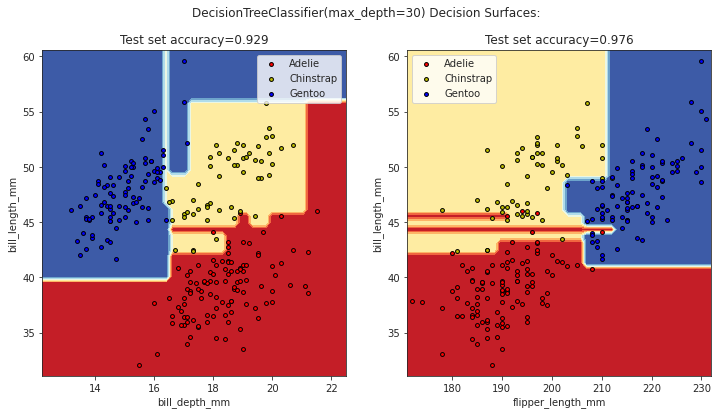

Rather reasonable:


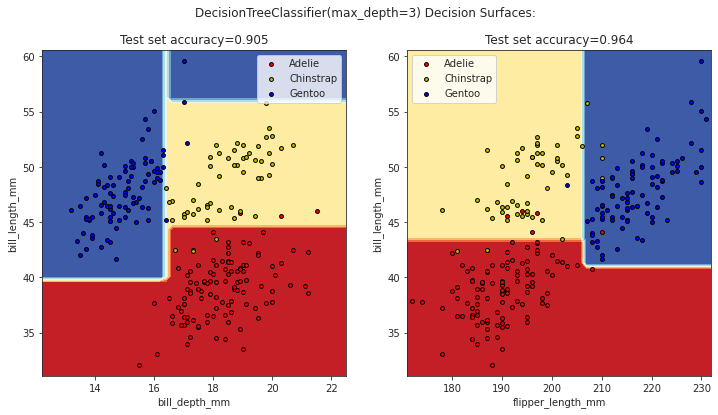

Too shallow tree unable to generalize!


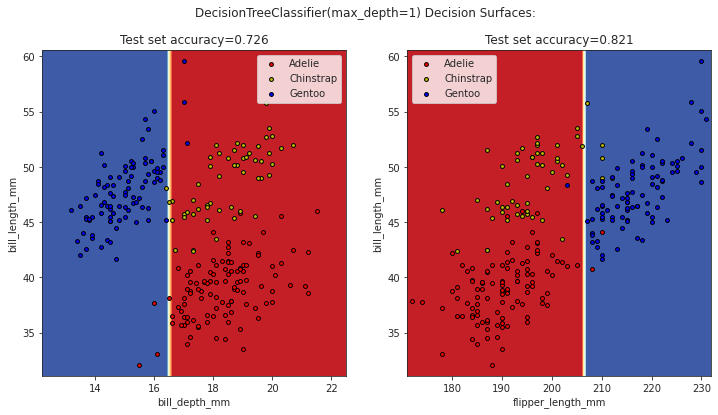

In [13]:
from utils.plot_utils import decision_surfaces_row    

feature_pair_list = [['bill_depth_mm', 'bill_length_mm'],
                     ['flipper_length_mm', 'bill_length_mm']]


def decision_surfaces_row_w_data(clf): 
    decision_surfaces_row(clf, X_train, y_train, X_test, y_test, feature_pair_list)
    plt.show()

print('Too deep tree overfitting to training set!')
tree_clf = DecisionTreeClassifier(max_depth=30) 
decision_surfaces_row_w_data(tree_clf) 

print('Rather reasonable:')
tree_clf = DecisionTreeClassifier(max_depth=3) 
decision_surfaces_row_w_data(tree_clf) 

print('Too shallow tree unable to generalize!')
tree_clf = DecisionTreeClassifier(max_depth=1) 
decision_surfaces_row_w_data(tree_clf) 


#### Look at the above images to get hold of *overfitting* and *underfitting*.
***
To think:
1. Given the definintion Def 1. What are the Task, Experience, and performace measure here?
2. Why does a deep tree easily overfit to training data.
3. Why are the class separation lines in above pictures always parallel to feature axises?
4. If you were to be asked how a tree ended up classifying this item as of belonging to species 'Gentoo' what would you do to figure it out?
5. Related to above what is a decision path in a tree classifier?
6. Can you device ways in which the tree classifier could be improved?
***

## Random Forest Classifier (RF):  

Single tree is prone to overfit. This can, however, be mitigated by bootstrap aggregating (bagging), the training set. Bagging is a process where from a (training) se $\mathbf{X}$ one randomly draws *with replacement* samples of size $n$. Now, fitting a single tree to such reduced sample is not as likely to overfit, however, it is also not as likely to perform as well as the original (at least if tuned) tree classifier. This tree fitted in the bootstrap aggregated sample is called **weak learner**. Combining bunch of such weak learners can lead to a strong classifier and you guessed it Random Forest is exactly a such a collection with only one small modification. 

To build an random forest we follow these four steps:
1. Draw random bootstrap sample from the training set.
2. Fit a decision tree to the just drawn sample. However,
    1. at each node select only a subset of features (without replacement)
    2. Find the best (feature, split\_value) given this subset of features.
3. Repeat steps two and three N times to grow a random forest of N estimators.
4. When predicting the class of an item take the majority vote of all the trees in the forest.

Random forests are super easy to tune. There is n practice only single value to consider, i.e., the amount of estimators, they are not likely to overfit and provide good all around performance. They are one of the most used ML models. The drawback when compared to tree classifiers is that one lost the interpretability that a single tree could still offer. However, even this can be questioned since a very deep decision treen can in practice be quite difficult to interpret (would you like to receive a hundred nodes long decision path?).
***
#### Using RF:
Again using random forests is easy - even more so than for tree classifiers since you do not necessarily need to worry about the hyperparameters.

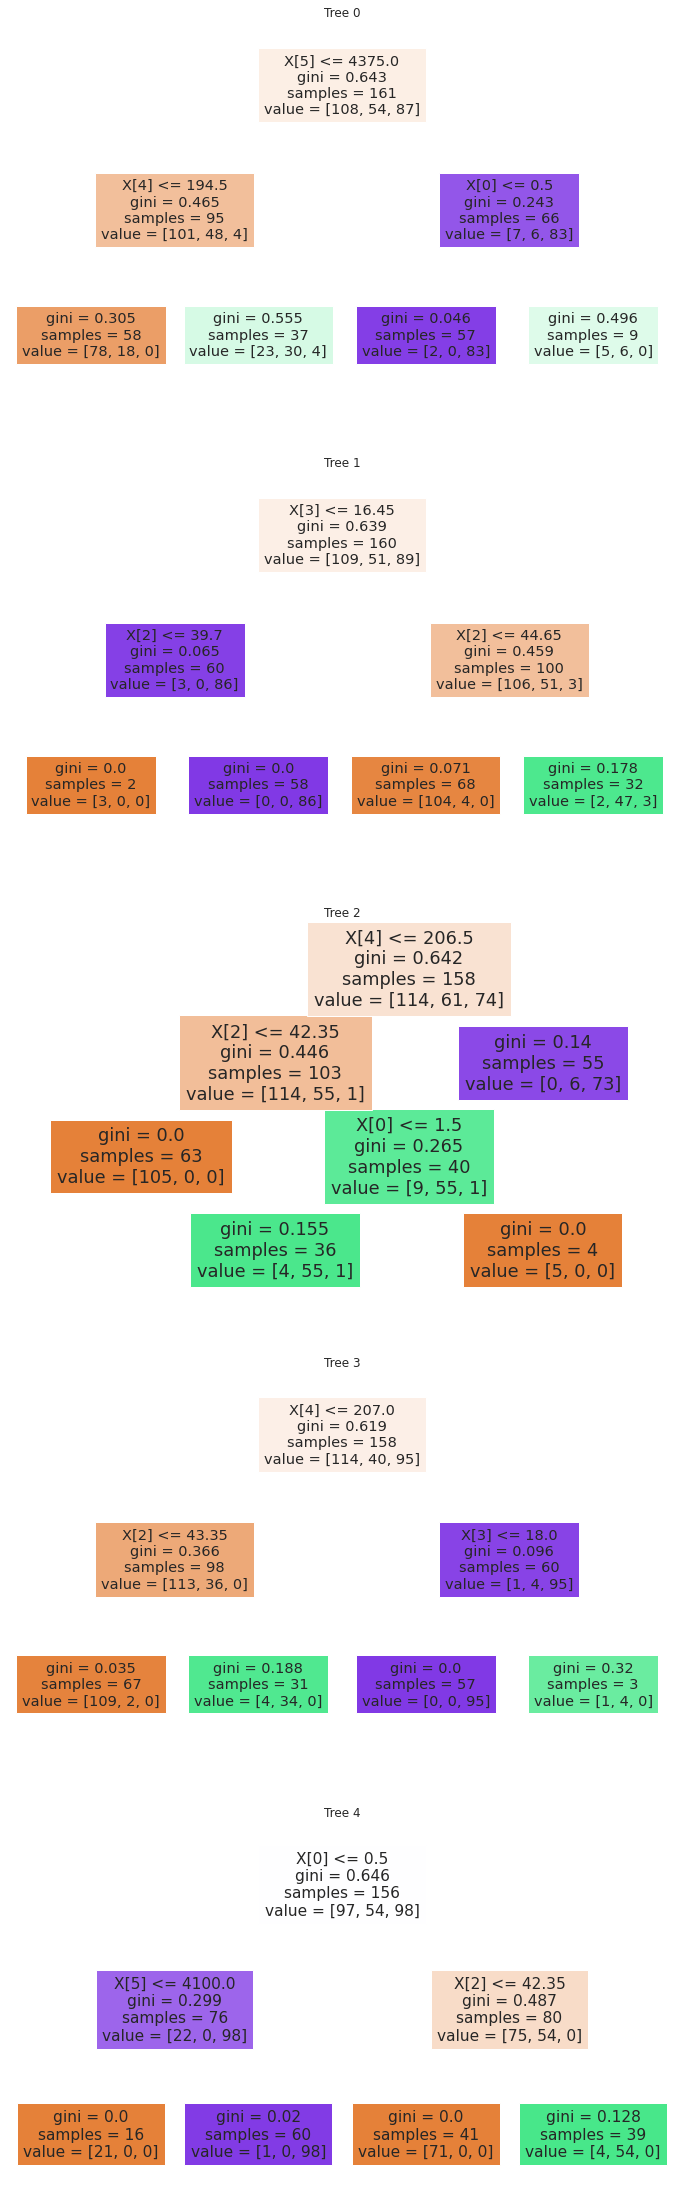

In [14]:
from sklearn.ensemble import RandomForestClassifier # Import the random foresst:
from sklearn.tree import plot_tree

# Create and fit the RF classifier:
rf = RandomForestClassifier(n_estimators=5, max_leaf_nodes=4).fit(X_train, y_train)

# ALL THIS FOR PLOTTING RF is aplready ready...
_, axarr = plt.subplots(rf.n_estimators, 1, figsize=(12, 40))

for i, tree_clf, ax in zip(range(rf.n_estimators), rf.estimators_, axarr):
    plot_tree(tree_clf, filled=True, ax=ax)
    ax.set_title('Tree {}'.format(i))
    

### To display the differences in Tree and RF classifiers complexity we shall now plot their decision surfaces in simple 2d case.

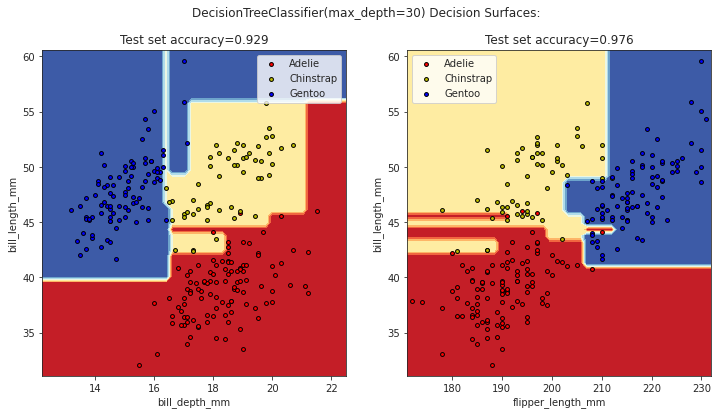

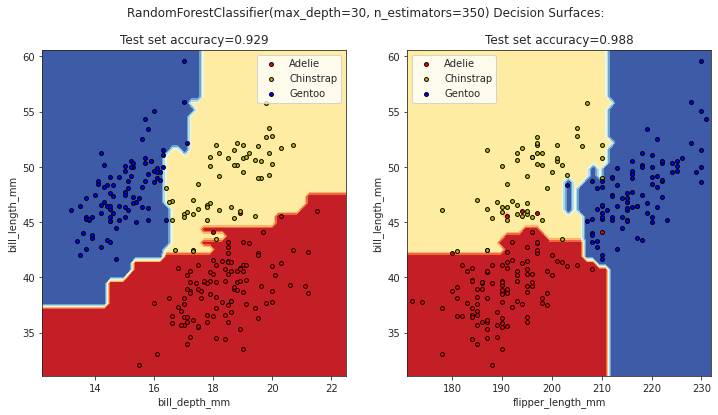

In [15]:
tree_clf = DecisionTreeClassifier(max_depth=30) 
decision_surfaces_row_w_data(tree_clf) 

# PLot for RF:
rf = RandomForestClassifier(n_estimators=350, max_depth=30) 
decision_surfaces_row_w_data(rf) 

### Underfitting/Overfitting

It is clear from the figures above, that the Tree classifier is doing something suboptimal. It is overfitting - let us now see how the classifier parameters can lead to under/overfitting.

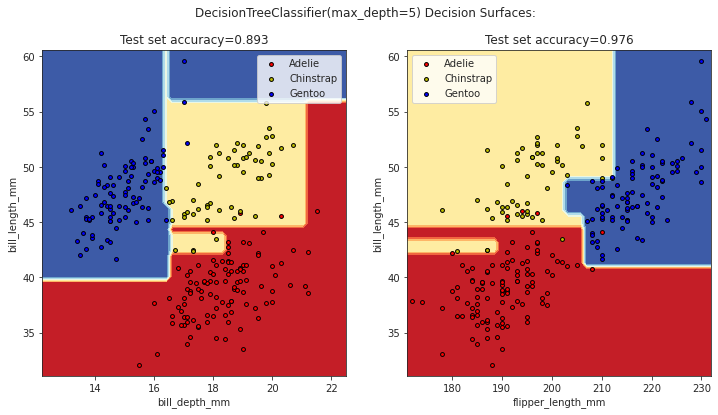

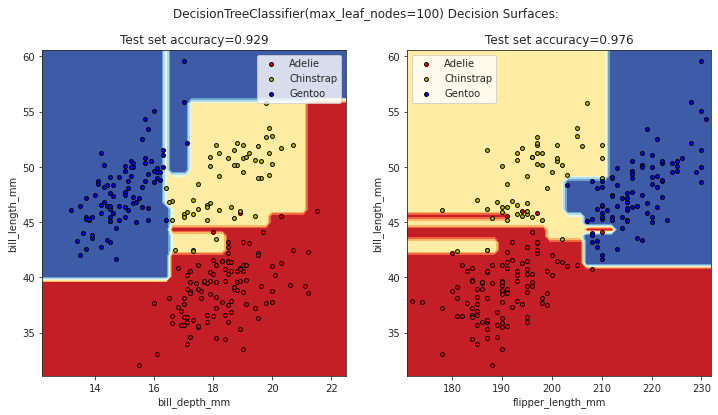

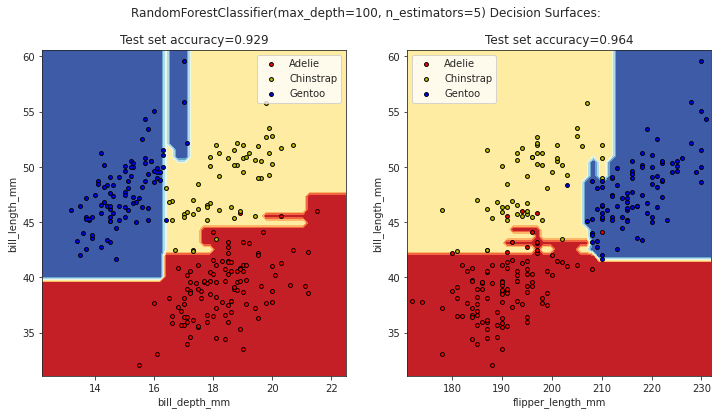

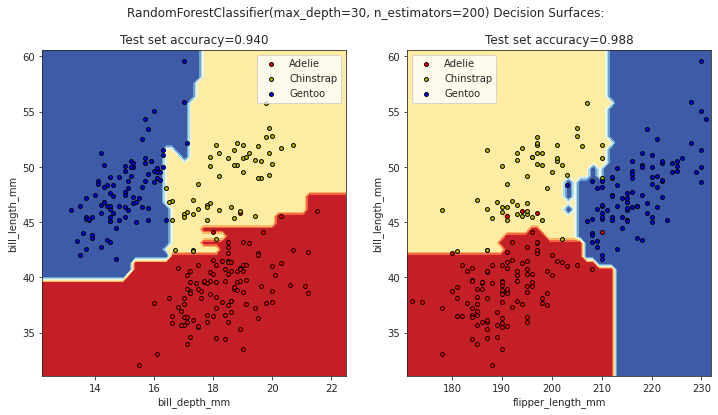

In [16]:
decision_surfaces_row_w_data(DecisionTreeClassifier(max_depth=5))
decision_surfaces_row_w_data(DecisionTreeClassifier(max_leaf_nodes=100))
decision_surfaces_row_w_data(RandomForestClassifier(n_estimators=5, max_depth=100))
decision_surfaces_row_w_data(RandomForestClassifier(n_estimators=200, max_depth=30))

To think:
1. Why does RF protect so well from overfitting?
2. Why RF instead of shallower tree?

***
### More complicated tasks:

Since we now have the RF at hand maybe we are ready to tackle something more complicated task than just penguin specieces. We shall import a dataset that has the incomes of bunch of people and some features related to those people. We will try to predict whether a person is going to make more than 50k\$ a year. First we shall take a look at the data as one would in a process of approachin such a task and then we'll use RF and Treee clfs to make predictions. 

In [17]:
from sklearn.datasets import fetch_openml

adult = fetch_openml(name='adult', version=2)
random_state = 42

X = pd.DataFrame(data=adult.data, columns=adult.feature_names).fillna(method='pad') 


for cat_feat, vals in adult.categories.items():
    map_d = dict(zip(range(len(vals)), vals))
    X.loc[:, cat_feat] = X.loc[:, cat_feat].astype(int).map(map_d).astype('category')
    
y = pd.Series(adult.target, name='income')


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)

data=pd.concat((X_train, y_train), axis=1)

display(X_train.head())
display(X_train.dtypes)
print('Target:', y)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
27859,41.0,Private,27187.0,Assoc-voc,11.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,2415.0,12.0,United-States
5654,39.0,Private,319052.0,Bachelors,13.0,Married-civ-spouse,Handlers-cleaners,Wife,Asian-Pac-Islander,Female,0.0,0.0,37.0,Philippines
3779,34.0,Private,260560.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,50.0,United-States
10522,56.0,Self-emp-not-inc,368797.0,Masters,14.0,Married-civ-spouse,Sales,Husband,White,Male,0.0,0.0,40.0,United-States
22461,71.0,Self-emp-not-inc,163293.0,Prof-school,15.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,2.0,United-States


age                float64
workclass         category
fnlwgt             float64
education         category
education-num      float64
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain       float64
capital-loss       float64
hours-per-week     float64
native-country    category
dtype: object

Target: 0        <=50K
1        <=50K
2         >50K
3         >50K
4        <=50K
         ...  
48837    <=50K
48838     >50K
48839    <=50K
48840    <=50K
48841     >50K
Name: income, Length: 48842, dtype: object


### Obviously we'll see the incomes of males vs females:

We need to create an array (makes_money) which denotes if a given person is to make more than 50K in a year. If no is value 0 and true is value 1 we can use the array to estimate probabilities of a person in group $G$ making more than 50K. This is because the number of people in $G$ making more than 50K is the sum over the array:

$
p(\text{>50K}| G) = \frac{\text{number of people making over 50K in group }G}{\text{Number of people in group }G} = \frac{\sum_{i \in G} \text{makes_money}_i}{|G|} = \text{mean(makes_money($G$))}
$

The stat function in seaborn barplot is by default the mean of the $y$ values in the subgroups and hence we can directly use barplot to obtain the probabilities.

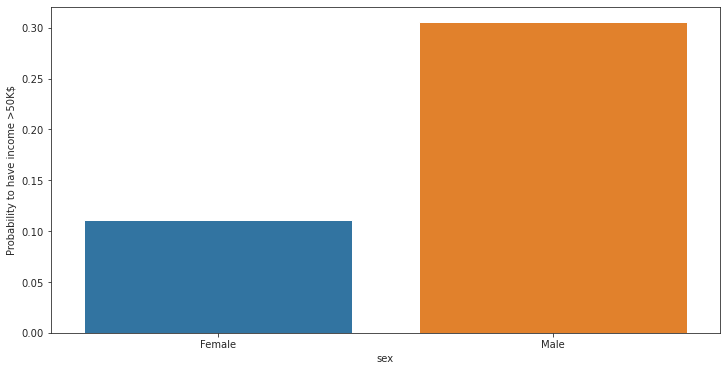

In [18]:
makes_money = (data.income=='>50K').astype(int)
# seaborn barplot takes the mean over y argument by default - by providing binary 0,1 as values we get estimate for the probability.
ax = sns.barplot(data=data, x='sex', y=makes_money, ci=None) 
_ = ax.set_ylabel('Probability to have income >50K$')

#### And there you have it...
***
How about when grouped with occupation?

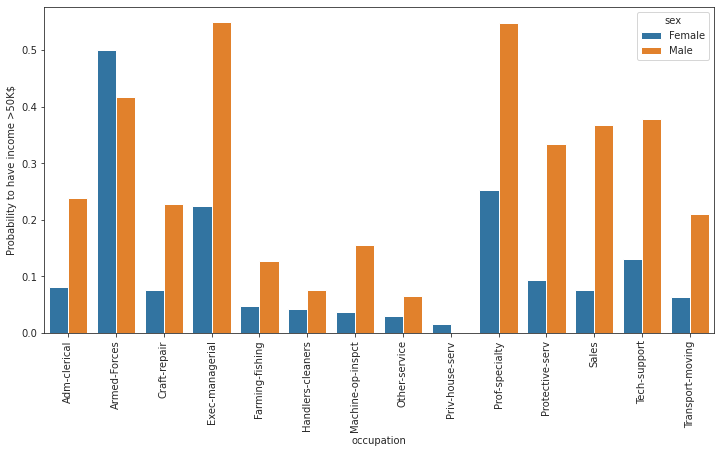

In [19]:
ax = sns.barplot(data=data, x='occupation', y=makes_money, hue='sex', ci=None) 
ax.set_ylabel('Probability to have income >50K$')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Throughout the line females are likely to make less money than their male colleagues? Such an discreparency is an issue which we all ought to try to solve.

Can you explain why it seems that the discreparency is not that striking in the armed forces?
***

### How about incomes in different education levels?

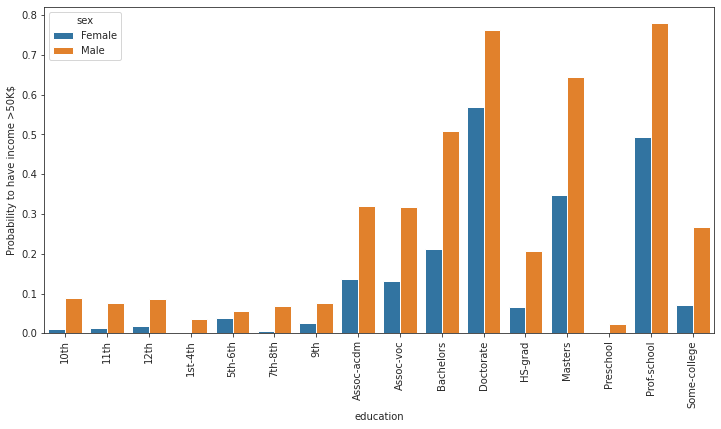

In [20]:
ax = sns.barplot(data=data, x='education', y=makes_money, hue='sex', ci=None) 
ax.set_ylabel('Probability to have income >50K$')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

### Marital status in different age groups?

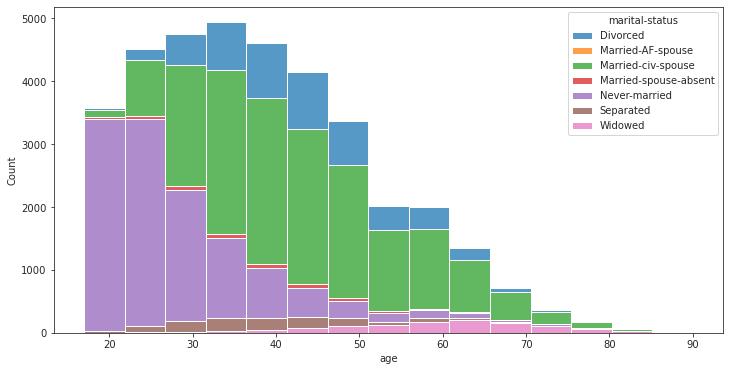

In [21]:
ax = sns.histplot(data=data, hue='marital-status', x=data.age, multiple='stack', bins=15, stat='count') 

### How about the age distributions for different income groups?

<AxesSubplot:xlabel='age', ylabel='Count'>

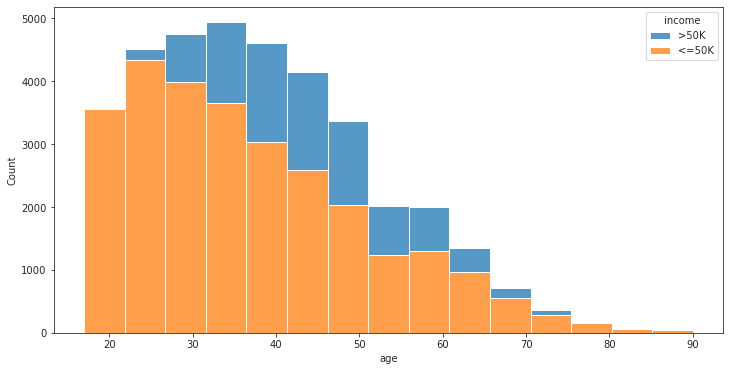

In [22]:
sns.histplot(data, hue='income', x='age', multiple='stack', bins=15)

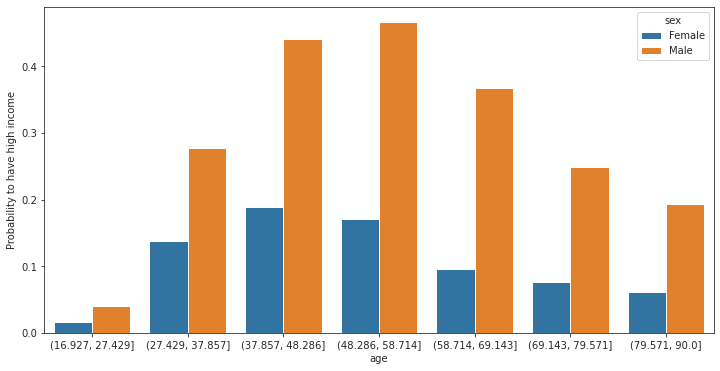

In [23]:
ax = sns.barplot(y=makes_money.astype(int), x=pd.cut(data.age, 7), hue=data.sex, ci=None)
_ = ax.set_ylabel('Probability to have high income')

#### The takeaway here is that if the data is such that you can extract some meaningful information from it before starting performing predictions - you should do it.
***
## Let us the build a RF classifier and try to optimize it for identifying the people that are having high incomes.

For the sake of demonstration, let us also perform some *hyperparameter* optimization. We tune the individual tree depth in RF. Let us see how the train and test scores develop as the trees are allowed to become deeper.

In [24]:
# Quickly encode the categorical features to numerical ones.
transformers = [('ord', OrdinalEnc(), make_column_selector(dtype_include=[object, 'category']))]
ct = ColumnTransformer(transformers, remainder='passthrough')

X_train_enc = ct.fit_transform(X_train)
X_test_enc = ct.transform(X_test)

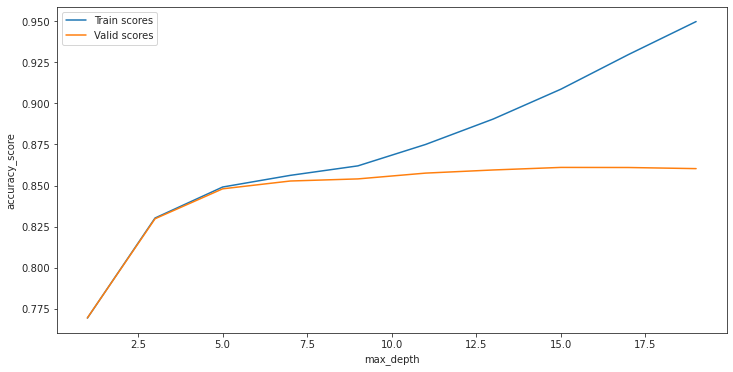

In [26]:
from sklearn.metrics import accuracy_score 

def plot_train_valid(clf, clf_args, score=accuracy_score):
    
    scores = np.zeros((len(clf_args), 3))
    
    for i, clf_arg in enumerate(clf_args):
        clf.set_params(**dict([clf_arg]))
        
        cv_dict = cross_validate(clf, X_train_enc, y_train, return_train_score=True, cv=3)
        
        scores[i, 0] = clf_arg[1]
        scores[i, 1] = cv_dict['train_score'].mean()
        scores[i, 2] = cv_dict['test_score'].mean()
        
    
    plt.plot(scores[:, 0], scores[:, 1], label='Train scores')
    plt.plot(scores[:, 0], scores[:, 2], label='Valid scores')
    plt.xlabel(clf_arg[0])
    plt.ylabel(score.__name__)
    plt.legend()
    plt.show()

rf = RandomForestClassifier(n_estimators=100, random_state=random_state)

clf_args = [('max_depth', max_d) for max_d in np.arange(1, 20, 2)]
plot_train_valid(rf, clf_args)

#### Lets pick max_depth=10 - this just reduces the tree sizes and as we can see should not affect performance. 
***
### Feature importances:
Some classifiers in sklearn, RF included provide measures for feature importances. This is basically a measure of how important the feature is considered by the classiifer when making an inference. Feature importances come with many issues in them - for example - heavily correlated features can hinder each others importances etc. We will not go into the details, but you can try if you can improve the validation perfromance by removing the least important features. Lets now do that:

In [27]:
rf = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=random_state)

feat_imps = rf.fit(X_train_enc, y_train).feature_importances_

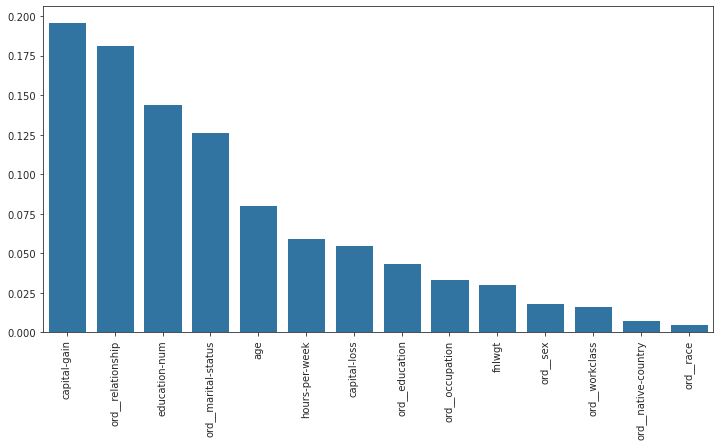

In [28]:
features = np.array(ct.get_feature_names())
sort_idx = feat_imps.argsort()[::-1]
ax = sns.barplot(x=features[sort_idx], y=feat_imps[sort_idx], color='C0')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

#### Lets now also see if reducing the number of features can give any better performance. It can also be beneficial especially from the interpretability perspective if one can omit some of the features.

In [29]:
sorted_features = features[sort_idx]

def get_n_most_important(n):
    most_important = sorted_features[:n]
    mask = np.isin(features, most_important)
    return mask, most_important

def print_features(mask):
    print('Using subset of features:', end='\n\t-')
    print('\n\t-'.join(features[mask]))
    

In [30]:
metric = 'accuracy'
cv = 3

score_data = []
for nfeat in range(1, len(features)+1):
    
    # Select the subset of features using feature mask:
    features_mask, _ = get_n_most_important(nfeat)
    X_train_sub = X_train_enc[:, features_mask]
    
    # Perfrom cross validation in the training set:
    cv_dict = cross_validate(rf, X_train_sub, y_train, 
                             scoring=metric, 
                             return_train_score=True, 
                             cv=cv)
    
    # Sotre the results into array and append it to list:
    scores = np.zeros((cv*2, 3))
    scores[:, 0] = nfeat
    scores[:cv, 2] = cv_dict['train_score']
    scores[:cv, 1] = 0 # for train
    scores[cv:, 2] = cv_dict['test_score']
    scores[cv:, 1] = 1 # for valid
    
    score_data.append(scores)
    
    # Print some runtime info:
    print_features(features_mask)
    print('-->Valid score: {:.4f}'.format(cv_dict['test_score'].mean()))
    print()
    
score_data = np.vstack(score_data)

Using subset of features:
	-capital-gain
-->Valid score: 0.8091

Using subset of features:
	-ord__relationship
	-capital-gain
-->Valid score: 0.8086

Using subset of features:
	-ord__relationship
	-education-num
	-capital-gain
-->Valid score: 0.8468

Using subset of features:
	-ord__marital-status
	-ord__relationship
	-education-num
	-capital-gain
-->Valid score: 0.8465

Using subset of features:
	-ord__marital-status
	-ord__relationship
	-age
	-education-num
	-capital-gain
-->Valid score: 0.8464

Using subset of features:
	-ord__marital-status
	-ord__relationship
	-age
	-education-num
	-capital-gain
	-hours-per-week
-->Valid score: 0.8500

Using subset of features:
	-ord__marital-status
	-ord__relationship
	-age
	-education-num
	-capital-gain
	-capital-loss
	-hours-per-week
-->Valid score: 0.8577

Using subset of features:
	-ord__education
	-ord__marital-status
	-ord__relationship
	-age
	-education-num
	-capital-gain
	-capital-loss
	-hours-per-week
-->Valid score: 0.8568

Using subset

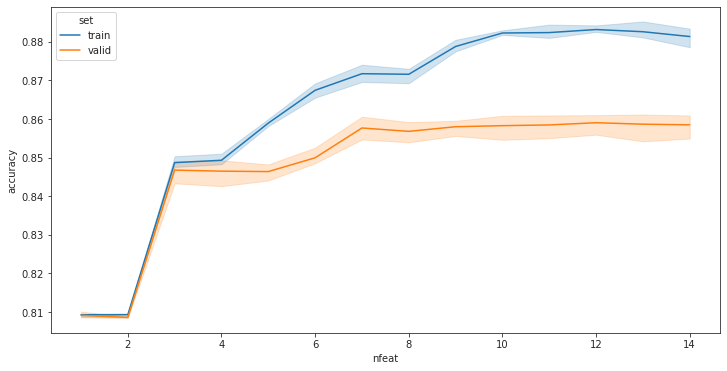

In [31]:
score_data_df = pd.DataFrame(data=score_data, columns=['nfeat', 'set', metric])
score_data_df.loc[:, 'set'] = score_data_df.loc[:, 'set'].map({0:'train', 1:'valid'})
_ = sns.lineplot(data=score_data_df, x='nfeat', y=metric, hue='set')

### Maybe we can be satisfied with only, say 12 features... Lets pick the 12 most important ones and report our final perfromance:
***
First let us still device a dummy classifier to have as a baseline that we definitely ought to beat:

In [32]:
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier 

dummy_sk = DummyClassifier(strategy='most_frequent').fit(X_test, y_test)

def dummy_clf(X_test):
    preds = np.ndarray(len(X_test), dtype='object')
    preds[:] = '<=50K'
    preds[X_test.education == 'Doctorate'] = '>50K'
    
    return preds

print(classification_report(y_test, dummy_clf(X_test), digits=4))
#print(classification_report(y_test, dummy_sk.predict(X_test), digits=4))

              precision    recall  f1-score   support

       <=50K     0.7720    0.9955    0.8696      9354
        >50K     0.7181    0.0375    0.0712      2857

    accuracy                         0.7714     12211
   macro avg     0.7451    0.5165    0.4704     12211
weighted avg     0.7594    0.7714    0.6828     12211



In [33]:
feature_mask, _ = get_n_most_important(12)
rf.fit(X_train_enc[:, feature_mask], y_train)

# Notice that X_test has NEVER been seen before:
print(classification_report(y_test, rf.predict(X_test_enc[:, feature_mask]), digits=4))

              precision    recall  f1-score   support

       <=50K     0.8858    0.9532    0.9182      9354
        >50K     0.7958    0.5975    0.6825      2857

    accuracy                         0.8700     12211
   macro avg     0.8408    0.7753    0.8004     12211
weighted avg     0.8647    0.8700    0.8631     12211



***
### How about if just skip all of the above and use all the default parameters and no feature selection:

In [34]:
rf_def = RandomForestClassifier(random_state=random_state).fit(X_train_enc, y_train)
print(classification_report(y_test, rf_def.predict(X_test_enc), digits=4))

              precision    recall  f1-score   support

       <=50K     0.8939    0.9341    0.9136      9354
        >50K     0.7471    0.6370    0.6877      2857

    accuracy                         0.8646     12211
   macro avg     0.8205    0.7856    0.8006     12211
weighted avg     0.8596    0.8646    0.8607     12211



### Nice... 
The default RF is almost as good as the heavily tuned one (depending on the random\_state it can actually be better)... RandomForests are popular basically bacuase of this - you are not likely to gain much with a tuning process, they have built in feature selection stradegy and offer overall good performance... As a side note try to beat the above results using nns...
***
## More on performance metrics:

Maybe it is also time to discuss a bit about the different metrics (apart from accuracy) to evaluate the classifier performance. You have already been seeing the classification_reports that report something called precision and recall scores. We will now figure out what those mean and in the process get to know *confusion matrix*.

The first thing one can notice that by predicting every single item in the test set as belonging to the '<=50K' group we still receive accuracy of 9354/(9354+2857)=76%. If not paying attention one might get fooled to think that a classifier achieving such accuracy is doing well! The issue becomes even more striking as the class fraction is reduced (what is the accuracy of such majority class clf in case where the majority class is 99% of the data instances?). 

Thus especially for *unbalanced* (=some of the classes are significantly more frequent than others) classification tasks it is required to consider more appropriate metrics. We shall now introduce the concept of *confusion matrix*:

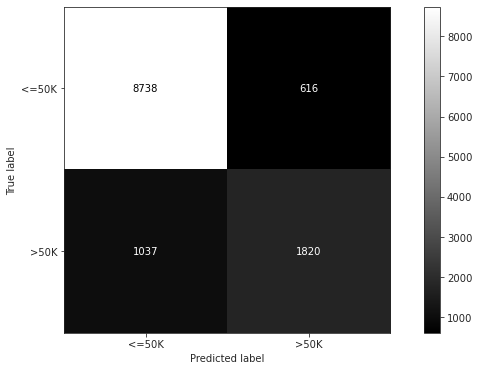

In [35]:
from sklearn.metrics import plot_confusion_matrix

_ = plot_confusion_matrix(rf_def, X_test_enc, y_test, cmap='gray')

All non-diagonal elements are classification errors. It is anyhow practical to name different types of errors differently. Say you were to make medical diagnostics of some severe disease $A$ (please if you are ever in this kind of situation think twice if this is good idea...). To aid the medical stuff you are to make an ML model that tries to pick up the persons having the condition $A$. It is most certainly likely that you would rather bother few additional persons who **do not have the condition** rather than **miss persons who has it**. This motivates the following definitions: 


* Predicting a person to have condition (>50K) while they do not have it in reality is called *type I* error or *False positive* (FP) in the above image they are the in the upper right corner.
* Missing a person with the condition is called *type II* error or *False negative* (FN) in the above image they are the in the lower left corner.
* True classifications are called *true negatives* (TN) for negative class and *true positives* (TP) for positive class, they are the upper left and lower right corners in the above CM, respectively.

It takes some time to get used to the usage of these terms (or at least for me took). You need to stare into the above figure long enough to get crasp of what is happening. 
* *False negatives* are called accordingly because the model **falsely** predicted an item to the **negative** class
* *False positives* are called accordingly because the model **falsely** predicted an item to the **positive** class

The concept of confusion matrix trivially generalizes for multiclass cases as you have seen in image classification. However, let us here stick with the binary one and think how we ought to use the *type I* and *type II* errors to better evaluate the model performance.


Relevant questions quite often are:
1. From the positive group (here ppl making more than >50K) *how large fraction the model is able to capture*? $\Rightarrow \text{recall} = \frac{\text{Number of items correctly labeled as belonging to positive class}}{\text{True number of items in positive class}} = \frac{\text{TP}}{\text{TP} + \text{FN}}.$
2. From the items predicted as belonging to positive class *how large fraction actually were positive*? $\Rightarrow \text{precision} = \frac{\text{Number of items correctly labeled to belong into the positive class}}{\text{Number of items labeled as belonging to the positive class}} = \frac{\text{TP}}{\text{TP} + \text{FP}}.$

The questions 1. and 2. correspond to **recall** and **precision** respectively. In the classification reports above you have already seen them. The point here is not to by heart learn the definitions (though they are pretty straightforward), but instead emphasize that model performance evaluation is not straightforward. You need to consider the application area, the cost of making mistakes (yes you model is going to make mistakes), and how to try to minimize that cost. These considerations are application specific and there is no silver bullet to it. Whenever, making a ML model, think where it is applied, what are the consequences of mistakes, what kind of mistakes you ought to expect, etc. Only after this try to device a metric that can somehow measure the performance of your model.

Anyhow, accuracy, precision, recall, and F1 score can let you make some sanity checks especially when working on simple tasks. Oh, and the F1 is just the harmonic mean of precision and recall:
$
\text{F1} = 2\frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}.
$

It is not maybe best practice to cite wikipedia, but you can go and check the possible metrics that one can generate from [ConfusionMatrix](https://en.wikipedia.org/wiki/Confusion_matrix)...
***
#### Let us now check the classification reports once again and also discuss the roles of precision and recall there:

              precision    recall  f1-score   support

       <=50K      0.894     0.934     0.914      9354
        >50K      0.747     0.637     0.688      2857

    accuracy                          0.865     12211
   macro avg      0.821     0.786     0.801     12211
weighted avg      0.860     0.865     0.861     12211

Precision = TP/(TP + FP) = 1820/(1820 + 616) = 0.747
Recall    = TP/(TP + FN) = 1820/(1820 + 1037) = 0.637


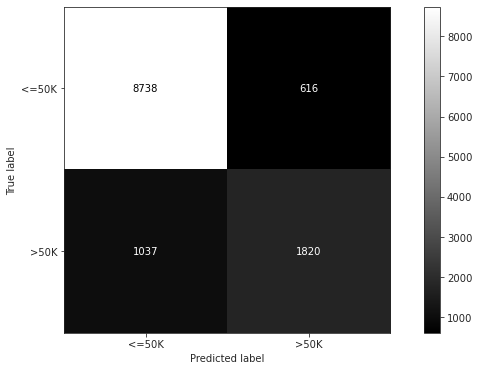

In [37]:
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, rf_def.predict(X_test_enc), digits=3))
CM = confusion_matrix(y_test, rf_def.predict(X_test_enc))

TP = CM[1,1]
FP = CM[0,1]
FN = CM[1,0]
TN = CM[0,0]
precision = TP/(TP + FP)
recall = TP/(TP + FN)

print('Precision = TP/(TP + FP) = {}/({} + {}) = {:.3f}'.format(TP, TP, FP, precision))
print('Recall    = TP/(TP + FN) = {}/({} + {}) = {:.3f}'.format(TP, TP, FN, recall))

_ = plot_confusion_matrix(rf_def, X_test_enc, y_test, cmap='gray')

Notice that obviously the choice of "positive class" is completely arbitrary and the role of positive and negative can be swapped. That is why the classification report reports the recall and precision for the "negative" (<=50K) class as well... 

In the above we are able to find roughly 2 out of three people making more than 50K - not super good especially considering that at the same time out of the predictions that we make for the 50K class one in four is wrong. Anyhow, such is life, you are not always succesfull, the task left would be to think if this kind of a model would be of any use or no... 

***
### Questions:
1. Why is the Decision surfaces of tree clf much more complicated as compared to rf classifier?
2. What does the max_depth parameter mean for the tree classifier?
3. Why a large max_depth can lead to overfitting?
4. Why does the tree obtain such a low score even while the figures above shoved that the training examples seemed to be perfectly separated?
5. How does RF protect against overfitting as compared to tree classifier?
6. What are advantages/disadvantages of RF?
7. How much you expect to improve in perfromance by spending a lot of time tuning an RF?
8. **JOKER**: Considering that the *capacity* of NN-models is enough to learn what is a cat or a dog, which seems super comlicated task in comparison to the income level task presented here. What you think is the reason they are unable (I know they are even if it was not demonstrated here ;)) to figure out the income levels in the adult dataset?
9. What kind of performance metrics would you implement for a self driving cars...?